In [1]:
# Import required libraries
import os, sys
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.colors as mcolors
# Add parent directory to system path
notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
sys.path.append(os.path.join(parent_dir, 'core'))

# Import from core directory
from algorithms import GD, OLSModel
from utils import set_randomness

In [2]:
def train_model(lr, y, yhat):
    n = len(y)
    d = 1
    model = OLSModel(torch.zeros((d,)))
    optimizer = GD(model.parameters(), lr=lr)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize tracking arrays
    thetas = torch.zeros(n+1, d, dtype=torch.float32)
    ys = torch.zeros(n+1, dtype=torch.float32)
    fs = torch.zeros(n+1, dtype=torch.float32)
    yhats = torch.zeros(n+1, dtype=torch.float32)
    losses = torch.zeros(n+1, dtype=torch.float32)
    gradients = torch.zeros(n+1, d, dtype=torch.float32)
    average_losses = torch.zeros(n+1, dtype=torch.float32)
    average_gradients = torch.zeros(n+1, d, dtype=torch.float32)
    
    model = model.to(device)
    loss_fn = nn.MSELoss()
    
    for t in range(n):
        y_t = y[t]
        f_t = yhat[t]
        r_t = y_t-f_t
        
        optimizer.zero_grad()
        thetas[t+1] = model.theta.detach().cpu()
        prediction = model(torch.ones(1).to(device))
        r_t = r_t.to(device)
        prediction.squeeze()
        loss = loss_fn(prediction, r_t)
        loss.backward()
        optimizer.step()
        
        ys[t+1] = y_t.detach().cpu()
        fs[t+1] = f_t
        yhats[t+1] = f_t + prediction
        losses[t+1] = loss.detach().cpu().item()
        gradients[t+1] = model.theta.grad.detach().cpu()
        average_losses[t+1] = losses[:t+1].mean()
        average_gradients[t+1] = gradients[:t+1].mean(dim=0)
        thetas[t+1] = model.theta.detach().cpu()
    
    return pd.DataFrame({
        'theta': thetas.tolist(),
        'y': ys.tolist(),
        'f': fs.tolist(),
        'yhat': yhats.tolist(),
        'loss': losses.tolist(),
        'gradient': gradients.tolist(),
        'average_gradient': average_gradients.tolist(),
        'average_loss': average_losses.tolist(),
        'lr': lr,
        't': torch.arange(1,len(ys)+1)
    })

In [3]:
# Cell for loading and preprocessing data
set_randomness(0)

# Load the COMPAS dataset
df = pd.read_json('./rewards.json')

# Prepare tensors
y = torch.tensor(df.helpfulness.to_numpy()).float()
yhat = torch.tensor(df.rm_reward.to_numpy()).float()
lrs = [0, 0.001, 0.01, 0.05]

In [12]:
results = []

for lr in tqdm(lrs, desc="Training models"):
    result_df = train_model(lr, y, yhat)
    results.append(result_df)

# Combine results
combined_df = pd.concat(results, ignore_index=True)
combined_df['norm of avg grad'] = combined_df['average_gradient'].apply(np.linalg.norm, ord=np.inf)

# Save results
os.makedirs('.cache/', exist_ok=True)
combined_df.to_pickle('.cache/debias.pkl')

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

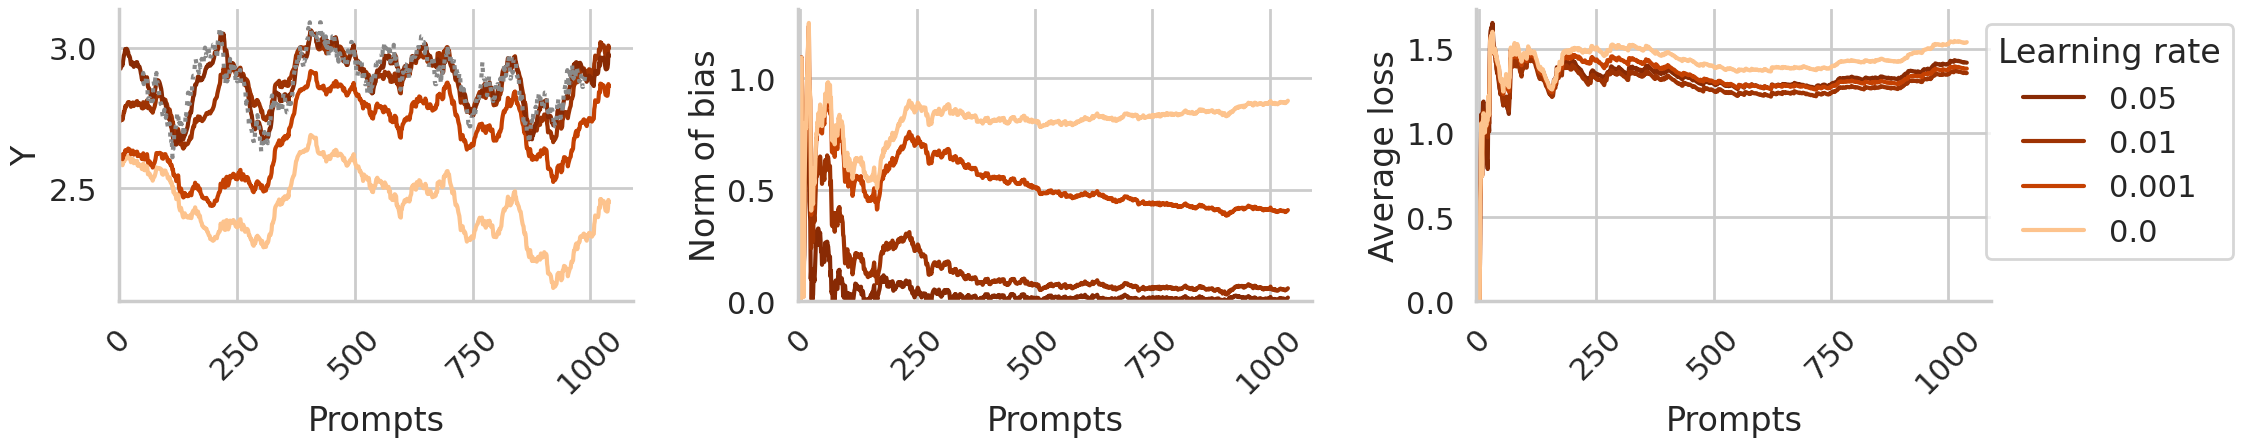

In [4]:
# Set styling
sns.set_style("whitegrid")
sns.set_context("poster")
sns.set_palette("pastel")

# Read from cache
combined_df = pd.read_pickle('.cache/debias.pkl')

# Create color map
lr_cmap = plt.cm.Oranges

# Use logarithmic normalization
# This ensures equal color spacing on a log scale
eps = 1e-8
norm = mcolors.LogNorm(vmin=min(np.array(lrs)+eps)/1000, vmax=max(np.array(lrs)+eps)*2)

# Create the colors by mapping the learning rates to the colormap
hues = {
    lr: lr_cmap(norm(lr+eps)) for lr in lrs
}

# Plot 1: Time Series Analysis
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(23,5), sharex=False, sharey=False)

# Get learning rates and create ordered lists
lr_values = sorted(combined_df['lr'].unique())
lr_values_reversed = sorted(combined_df['lr'].unique(), reverse=True)

# Define rolling window size
window_size = 100

# Left plot: Rolling average for predictions
# Predictions for each learning rate (plot these first)
pred_df = combined_df.copy()
pred_df['yhat_rolling'] = pred_df.groupby('lr')['yhat'].transform(
    lambda x: x.rolling(window=window_size, min_periods=1, center=True).mean()
)
_lp = sns.lineplot(ax=axs[0], data=pred_df, 
                  x=pred_df.t,  # Add x parameter
                  y="yhat_rolling",
                  hue="lr", palette=hues,
                  estimator=None, n_boot=0,
                  hue_order=lr_values)

# True values (plot these last so they appear on top)
true_df = combined_df[combined_df.lr == 0].copy()
true_df['y_rolling'] = true_df['y'].rolling(window=window_size, center=True).mean()
sns.lineplot(ax=axs[0], data=true_df, 
            x=true_df.t,  # Add x parameter
            y="y_rolling", color="#888888",
            estimator=None, n_boot=0, label="True Values",
            linestyle=":", zorder=10)  # Higher zorder ensures it's drawn on top

axs[0].set_ylabel("Y")
axs[0].set_xlim([0,None])
_lp.get_legend().remove()

# Middle plot: Gradient norm
_lp = sns.lineplot(ax=axs[1], data=combined_df, 
                   x=combined_df.t,  # Add x parameter
                   y="norm of avg grad", 
                   hue="lr", palette=hues,
                   estimator=None, n_boot=0,
                   hue_order=lr_values_reversed)
axs[1].set_ylabel("Norm of bias")
axs[1].set_ylim([0,None])
axs[1].set_xlim([-5,None])
_lp.get_legend().remove()

# Right plot: Average loss
_lp = sns.lineplot(ax=axs[2], data=combined_df,
                  x=combined_df.t,  # Add x parameter
                  y="average_loss", hue="lr", palette=hues,
                  estimator=None, n_boot=0,
                  hue_order=lr_values_reversed)
axs[2].set_ylabel("Average loss")
axs[2].set_ylim([0,None])
axs[2].legend(loc="upper right", bbox_to_anchor=(1.5,1), title='Learning rate')
axs[2].set_xlim([-5,None])

for ax in axs:
    ax.set_xlabel("Prompts")
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
sns.despine(top=True, right=True)
plt.tight_layout()
os.makedirs('./plots/debias', exist_ok=True)
plt.savefig('./plots/debias/series.pdf')
plt.show()